In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import pyblock
from scipy.special import logsumexp
from scipy.special import softmax

# matplotlib settings
# --- Publication style settings ---
plt.rcParams.update({
    # Font
    "font.family": "Times New Roman",
    "font.serif": ["Arial"],  # or other preferred serif font
    "mathtext.fontset": "cm",            # Computer Modern for math text
    "text.usetex": False,                 # Use LaTeX for text rendering]
    "pdf.fonttype": 42,                 # Use LaTeX for text rendering

    # Figure
    "figure.figsize": (6, 4),            # width, height in inches
    "figure.dpi": 300,                   # high resolution

    # Axes
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "axes.linewidth": 1.2,
    "axes.grid": True,                   # optional, remove if you want no grid
    "grid.linestyle": "--",
    "grid.alpha": 0.7,

    # Ticks
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.top": True,
    "ytick.right": True,

    # Lines
    "lines.linewidth": 2,
    "lines.markersize": 6,

    # Legend
    "legend.fontsize": 10,
    "legend.frameon": False
})



# Function to calculate per-residue helicity per frame
def dssp_to_helicity(dssp_lines):
    """
    Convert DSSP strings into a binary helicity matrix.
    
    Parameters
    ----------
    dssp_lines : list of str
        Each entry corresponds to one frame.
        Each string is the DSSP assignment per residue for that frame.
    
    Returns
    -------
    helicity : np.ndarray
        Array of shape (n_frames, n_residues).
        1 = helix ('H', 'G', 'I'), 0 = non-helix.
    """
    helix_codes = {'H', 'G', 'I'}
    
    n_frames = len(dssp_lines)
    n_residues = len(dssp_lines[0])
    
    helicity = np.zeros((n_frames, n_residues), dtype=int)
    
    for i, line in enumerate(dssp_lines):
        helicity[i, :] = [1 if c in helix_codes else 0 for c in line]
    
    return helicity

# read_colvar function which sorts colvar for unique entries from the back (i.e., second entry retained)
def read_colvar(colvar_file):

    data = np.loadtxt(colvar_file)
    # inverse order
    data = data[::-1]
    unique_idxs = np.array(np.unique(data[:,0], return_index=True)[1]).astype(int)[::-1] # find unique indices, first occurences
    data = data[unique_idxs]
    # original order
    data = data[::-1]

    return data


data_path = '../Ensemble_reweighting/'
rew_dir = 'opes_rew_cs_pre/'
protein = 'ACTR_OPES_310K_ensemble'
savepath = './cooperativity/'

In [3]:
# load data

helix_regions = [
    (11, 16), # helix 0, not part of CBP complex
    (27, 41), # h1
    (47, 54), # h2
    (56, 63), # h3
]

# dssp
ntrajs=5
opes_weights = np.loadtxt(data_path+f'{protein}/weights_310K.txt')
frames = np.loadtxt(data_path+rew_dir+f"PREframes.txt").astype(int)
opes_weights = opes_weights[frames]

residues = np.arange(1, 71+1)
for i in range(ntrajs):
    if i==0:
        with open(data_path+f'{protein}/dssp_data/dssp{i}.dat') as f:
            dssp = [line.strip() for line in f]
        dssp =  np.array(dssp)
    else:
        with open(data_path+f'{protein}/dssp_data/dssp{i}.dat') as f:
            tmpdssp = [line.strip() for line in f]
        tmpdssp =  np.array(tmpdssp)
        dssp = np.concatenate((dssp, tmpdssp), axis=0)

dssp = dssp[frames]

# weights from reweighting
tc = 5.0
# Load data
wopt_array = np.load(data_path+rew_dir+f'rew_wopt_array{tc}ns.npy')
neffs = np.loadtxt(data_path+rew_dir+f'rew_neffs{tc}ns.txt')
# Find the last index where neffs > 0.2
idx_opt = np.where(neffs > 0.2)[0][-1]
print(idx_opt)
wopt = wopt_array[idx_opt]

dssp.shape

18


(60034,)

In [4]:
# cooperativity of helices

from itertools import combinations

# =========================
# PARAMETERS
# =========================
helical_states = np.array(['H', 'G', 'I'])
# helical regions defined by https://pubs.acs.org/doi/10.1021/ja4045532 according to NMR secondary chemical shifts
helix_regions = [
    (6, 18),   # helix 0 
    (27, 38),  # helix 1 
    (47, 55),  # helix 2 
    (57, 64),  # helix 3 
]

weights = wopt
W = weights.sum()

thresholds = [0.5, 0.6, 0.7, 0.8]  # fraction cutoffs

# =========================
# DSSP strings → helical mask
# =========================
n_frames = dssp.shape[0]
n_residues = len(dssp[0])

dssp_chars = np.array([list(s) for s in dssp])
is_helical = np.isin(dssp_chars, helical_states)

# =========================
# Loop over thresholds
# =========================
for thresh in thresholds:
    print(f"\n==================== Threshold: {thresh} ====================")

    # -------------------------
    # Helix folded per frame
    # -------------------------
    n_helices = len(helix_regions)
    helix_folded = np.zeros((n_frames, n_helices), dtype=bool)

    for h, (start, end) in enumerate(helix_regions):
        idx = np.arange(start - 1, end)
        frac_helical = is_helical[:, idx].mean(axis=1)
        helix_folded[:, h] = frac_helical > thresh

    # -------------------------
    # Single-helix probabilities
    # -------------------------
    P_helix = (helix_folded * weights[:, None]).sum(axis=0) / W
    print("Single-helix folding probabilities:")
    for i, p in enumerate(P_helix):
        print(f"Helix {i}: P = {p:.4f}")

    # Save single-helix probabilities
    df_single = pd.DataFrame({
        "Helix": [f"h{h}" for h in range(n_helices)],
        "P_folded": P_helix
    })
    df_single.to_csv(savepath+f"single_helix_prob_thresh_{thresh:.1f}.csv", index=False)

    # -------------------------
    # Pairwise cooperativity
    # -------------------------
    print("\nHelix pair cooperativity:")
    pairwise_data = []
    for i, j in combinations(range(n_helices), 2):
        both_folded = helix_folded[:, i] & helix_folded[:, j]
        P_obs = (both_folded * weights).sum() / W
        P_rand = P_helix[i] * P_helix[j]
        ratio = P_obs / P_rand if P_rand > 0 else np.nan
        deltaP = P_obs - P_rand
        print(
            f"Helix {i}-{j}: "
            f"P_obs={P_obs:.4f}, "
            f"P_rand={P_rand:.4f}, "
            f"ratio={ratio:.2f}, "
            f"ΔP={deltaP:.4f}"
        )
        pairwise_data.append({
            "Helix_i": f"h{i}",
            "Helix_j": f"h{j}",
            "P_obs": P_obs,
            "P_rand": P_rand,
            "ratio": ratio,
            "deltaP": deltaP
        })
    # Save pairwise cooperativity
    df_pairwise = pd.DataFrame(pairwise_data)
    df_pairwise.to_csv(savepath+f"pairwise_coop_thresh_{thresh:.1f}.csv", index=False)

    # -------------------------
    # 3-helix joint probability (helices 1,2,3)
    # -------------------------
    h123 = helix_folded[:, 1] & helix_folded[:, 2] & helix_folded[:, 3]
    P123_obs = (h123 * weights).sum() / W
    P123_rand = P_helix[1] * P_helix[2] * P_helix[3]
    ratio123 = P123_obs / P123_rand if P123_rand > 0 else np.nan
    deltaP123 = P123_obs - P123_rand

    print("\n3-helix cooperativity (helices 1–2–3):")
    print(
        f"P_obs={P123_obs:.5f}, "
        f"P_rand={P123_rand:.5f}, "
        f"ratio={ratio123:.2f}, "
        f"ΔP={deltaP123:.5f}"
    )

    # Save 3-helix joint probability
    df_3helix = pd.DataFrame([{
        "Helices": "h1-h2-h3",
        "P_obs": P123_obs,
        "P_rand": P123_rand,
        "ratio": ratio123,
        "deltaP": deltaP123
    }])
    df_3helix.to_csv(savepath+f"3helix_coop_thresh_{thresh:.1f}.csv", index=False)



==================== Threshold: 0.5 ====================
Single-helix folding probabilities:
Helix 0: P = 0.0467
Helix 1: P = 0.2816
Helix 2: P = 0.0903
Helix 3: P = 0.0517

Helix pair cooperativity:
Helix 0-1: P_obs=0.0296, P_rand=0.0132, ratio=2.25, ΔP=0.0164
Helix 0-2: P_obs=0.0073, P_rand=0.0042, ratio=1.72, ΔP=0.0030
Helix 0-3: P_obs=0.0009, P_rand=0.0024, ratio=0.37, ΔP=-0.0015
Helix 1-2: P_obs=0.0610, P_rand=0.0254, ratio=2.40, ΔP=0.0356
Helix 1-3: P_obs=0.0170, P_rand=0.0146, ratio=1.17, ΔP=0.0024
Helix 2-3: P_obs=0.0095, P_rand=0.0047, ratio=2.03, ΔP=0.0048

3-helix cooperativity (helices 1–2–3):
P_obs=0.00845, P_rand=0.00132, ratio=6.42, ΔP=0.00713

==================== Threshold: 0.6 ====================
Single-helix folding probabilities:
Helix 0: P = 0.0069
Helix 1: P = 0.2098
Helix 2: P = 0.0552
Helix 3: P = 0.0517

Helix pair cooperativity:
Helix 0-1: P_obs=0.0055, P_rand=0.0015, ratio=3.78, ΔP=0.0040
Helix 0-2: P_obs=0.0010, P_rand=0.0004, ratio=2.63, ΔP=0.0006
Helix 0

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


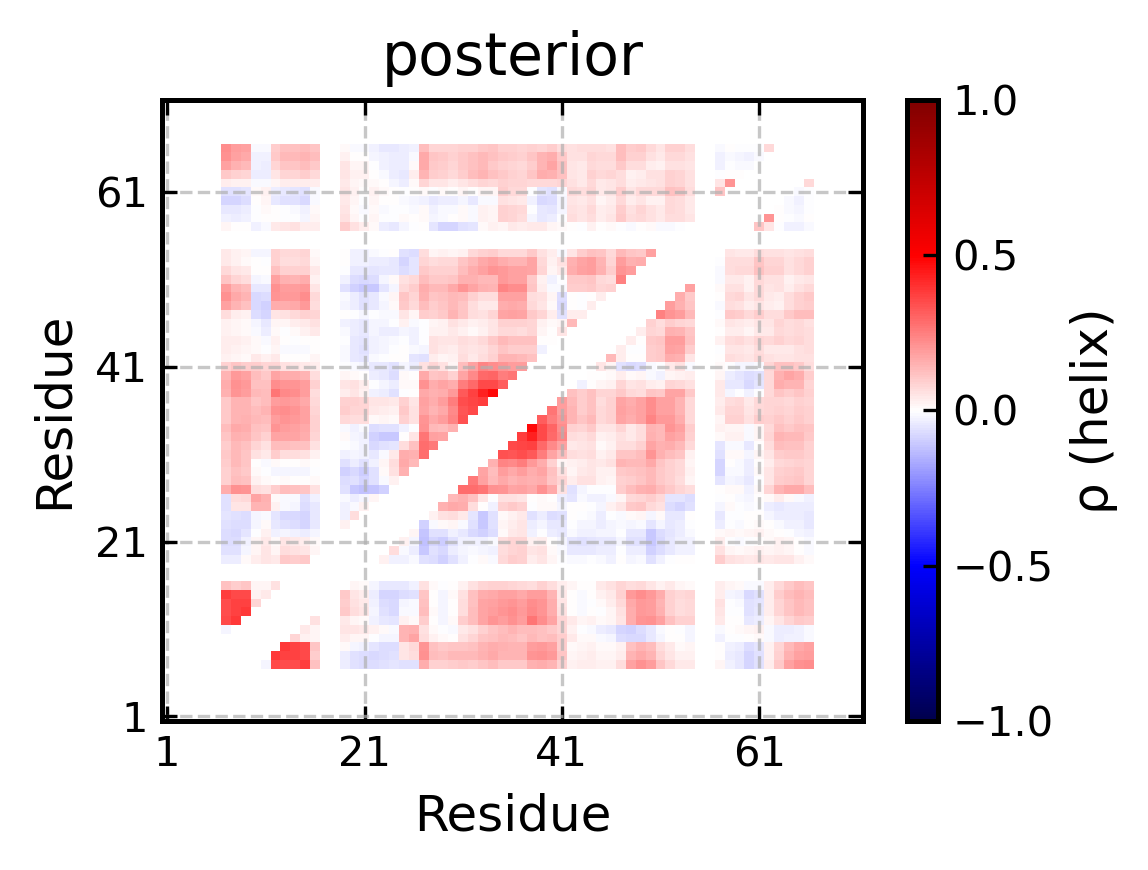

In [5]:
# residue pairwise helix correlation from dssp

# =========================
# PARAMETERS
# =========================
helical_states = np.array(['H', 'G', 'I'])
weights = wopt
W = weights.sum()

pmin = 0.01     # mask residues with very low helix probability
min_sep = 4      # minimum sequence separation for plotting

# =========================
# DSSP → helical mask
# =========================
# dssp: (n_frames,), each entry is a string
n_frames = len(dssp)
n_residues = len(dssp[0])

# Convert DSSP strings to array of characters
dssp_chars = np.array([list(s) for s in dssp])  # shape (frames, residues)

# Boolean mask: 1 if helical (H/G/I)
is_helical = np.isin(dssp_chars, helical_states).astype(float)  # use float for weighted mean

# =========================
# Weighted single-residue probabilities
# =========================
P_single = (is_helical * weights[:, None]).sum(axis=0) / W

# Mask low-probability residues
mask_prob = P_single >= pmin

# =========================
# Weighted means and std for correlation
# =========================
mean_i = P_single
std_i = np.sqrt(((is_helical - mean_i)**2 * weights[:, None]).sum(axis=0) / W)

# =========================
# Correlation matrix
# =========================
corr = np.full((n_residues, n_residues), np.nan)

for i in range(n_residues):
    if not mask_prob[i]:
        continue
    xi = is_helical[:, i]
    for j in range(i, n_residues):
        if not mask_prob[j]:
            continue
        # skip near-diagonal if desired
        if abs(i - j) < min_sep:
            continue
        xj = is_helical[:, j]
        cov_ij = ((xi - mean_i[i]) * (xj - mean_i[j]) * weights).sum() / W
        corr_ij = cov_ij / (std_i[i] * std_i[j]) if std_i[i]*std_i[j] != 0 else np.nan
        corr[i, j] = corr_ij
        corr[j, i] = corr_ij  # symmetry

# =========================
# Plot
# =========================
plt.figure(figsize=(4,3))
im = plt.imshow(corr, origin='lower', cmap='seismic', aspect='auto', vmin=-1, vmax=1)

cbar = plt.colorbar(im)
cbar.set_label("\u03C1 (helix)")

plt.xlabel("Residue")
plt.ylabel("Residue")

plt.xticks(ticks=[0,20, 40, 60], labels = [1, 21, 41, 61])
plt.yticks(ticks=[0,20, 40, 60], labels = [1, 21, 41, 61])
plt.title('posterior')


plt.tight_layout()
plt.savefig(savepath+f"helix_correlation_residue_matrix.pdf")


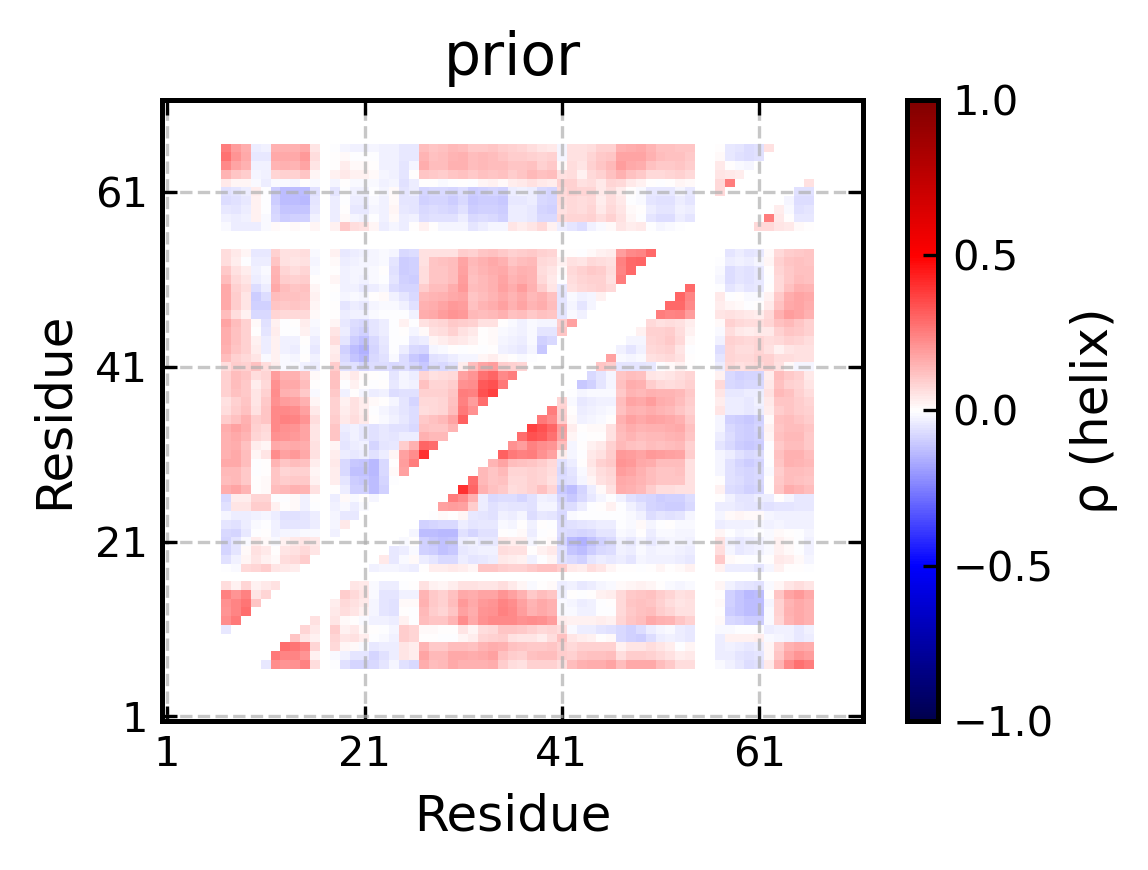

In [14]:
# residue pairwise helix correlation from dssp

# =========================
# PARAMETERS
# =========================
helical_states = np.array(['H', 'G', 'I'])
weights = opes_weights
W = weights.sum()

pmin = 0.01     # mask residues with very low helix probability
min_sep = 4      # minimum sequence separation for plotting

# =========================
# DSSP → helical mask
# =========================
# dssp: (n_frames,), each entry is a string
n_frames = len(dssp)
n_residues = len(dssp[0])

# Convert DSSP strings to array of characters
dssp_chars = np.array([list(s) for s in dssp])  # shape (frames, residues)

# Boolean mask: 1 if helical (H/G/I)
is_helical = np.isin(dssp_chars, helical_states).astype(float)  # use float for weighted mean

# =========================
# Weighted single-residue probabilities
# =========================
P_single = (is_helical * weights[:, None]).sum(axis=0) / W

# Mask low-probability residues
mask_prob = P_single >= pmin

# =========================
# Weighted means and std for correlation
# =========================
mean_i = P_single
std_i = np.sqrt(((is_helical - mean_i)**2 * weights[:, None]).sum(axis=0) / W)

# =========================
# Correlation matrix
# =========================
corr = np.full((n_residues, n_residues), np.nan)

for i in range(n_residues):
    if not mask_prob[i]:
        continue
    xi = is_helical[:, i]
    for j in range(i, n_residues):
        if not mask_prob[j]:
            continue
        # skip near-diagonal if desired
        if abs(i - j) < min_sep:
            continue
        xj = is_helical[:, j]
        cov_ij = ((xi - mean_i[i]) * (xj - mean_i[j]) * weights).sum() / W
        corr_ij = cov_ij / (std_i[i] * std_i[j]) if std_i[i]*std_i[j] != 0 else np.nan
        corr[i, j] = corr_ij
        corr[j, i] = corr_ij  # symmetry

# =========================
# Plot
# =========================
plt.figure(figsize=(4,3))
im = plt.imshow(corr, origin='lower', cmap='seismic', aspect='auto', vmin=-1, vmax=1)

cbar = plt.colorbar(im)
cbar.set_label("\u03C1 (helix)")

plt.xlabel("Residue")
plt.ylabel("Residue")

plt.xticks(ticks=[0,20, 40, 60], labels = [1, 21, 41, 61])
plt.yticks(ticks=[0,20, 40, 60], labels = [1, 21, 41, 61])
plt.title('prior')


plt.tight_layout()
plt.savefig(savepath+f"helix_correlation_residue_matrix_prior.pdf")


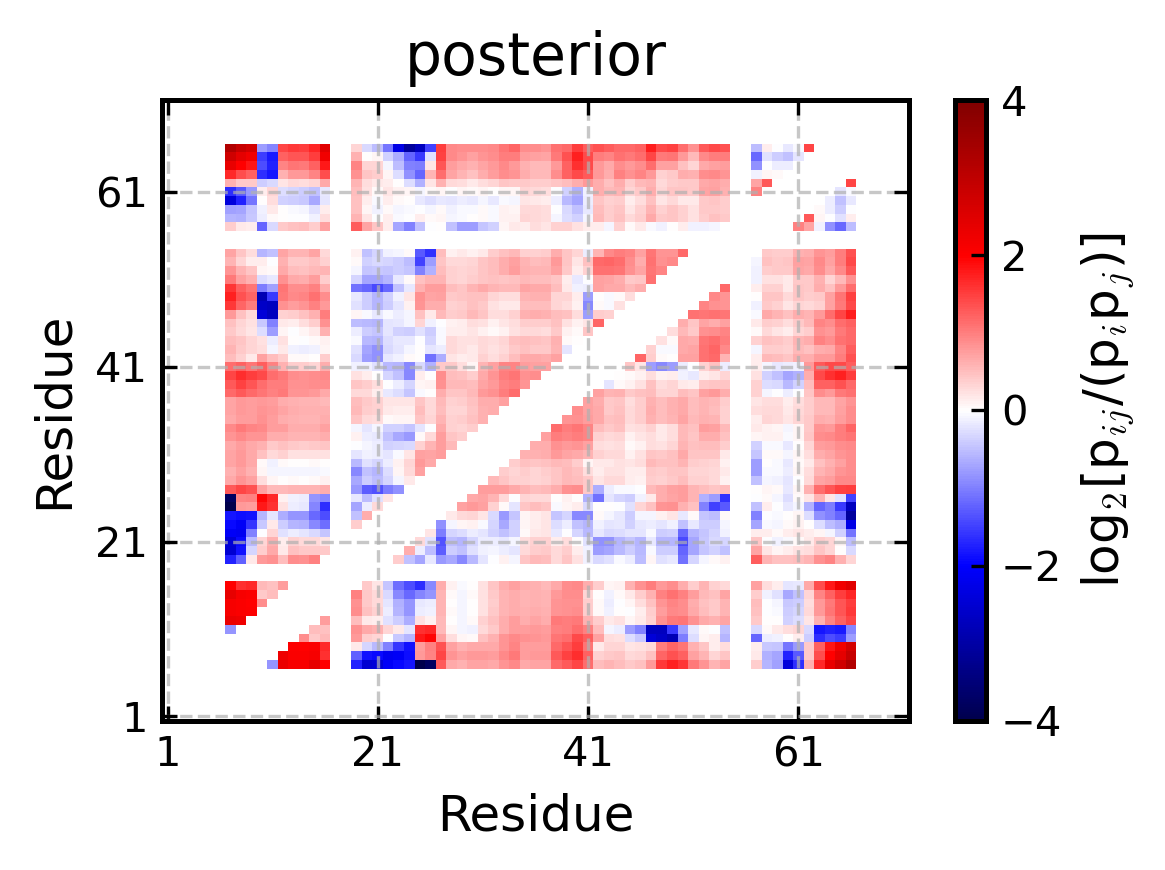

In [15]:
# =========================
# Residue pairwise helix cooperativity from DSSP
# C_ij = p_ij / (p_i * p_j)
# =========================

# =========================
# PARAMETERS
# =========================
helical_states = np.array(['H', 'G', 'I'])
weights = wopt
W = weights.sum()

pmin = 0.01     # mask residues with very low helix probability
min_sep = 4     # minimum sequence separation for plotting

# =========================
# DSSP → helical mask
# =========================
# dssp: (n_frames,), each entry is a string
n_frames = len(dssp)
n_residues = len(dssp[0])

# Convert DSSP strings to array of characters
dssp_chars = np.array([list(s) for s in dssp])  # (frames, residues)

# Boolean mask: 1 if helical (H/G/I)
is_helical = np.isin(dssp_chars, helical_states).astype(float)

# =========================
# Weighted single-residue probabilities p_i
# =========================
P_single = (is_helical * weights[:, None]).sum(axis=0) / W

# Mask low-probability residues
mask_prob = P_single >= pmin

# =========================
# Pairwise cooperativity matrix
# =========================
coop = np.full((n_residues, n_residues), np.nan)

for i in range(n_residues):
    if not mask_prob[i]:
        continue

    xi = is_helical[:, i]

    for j in range(i, n_residues):
        if not mask_prob[j]:
            continue

        # skip near-diagonal
        if abs(i - j) < min_sep:
            continue

        xj = is_helical[:, j]

        # weighted joint probability p_ij
        p_ij = (xi * xj * weights).sum() / W

        denom = P_single[i] * P_single[j]
        coop_ij = p_ij / denom if denom > 0 else np.nan

        coop[i, j] = coop_ij
        coop[j, i] = coop_ij  # symmetry

# =========================
# Plot (log2 cooperativity)
# =========================
plt.figure(figsize=(4, 3))
im = plt.imshow(
    np.log2(coop),
    origin='lower',
    cmap='seismic',
    aspect='auto',
    vmin=-4, vmax=4
)

cbar = plt.colorbar(im)
cbar.set_label("log$_2$[p$_{ij}$/(p$_i$p$_j$)]")

plt.xlabel("Residue")
plt.ylabel("Residue")

plt.xticks(ticks=[0, 20, 40, 60], labels=[1, 21, 41, 61])
plt.yticks(ticks=[0, 20, 40, 60], labels=[1, 21, 41, 61])
plt.title('posterior')

plt.tight_layout()
plt.savefig(savepath + "helix_cooperativity_residue_matrix.pdf")



/tmp/ipykernel_653351/52447752.py:72: RuntimeWarning: divide by zero encountered in log2
  np.log2(coop),


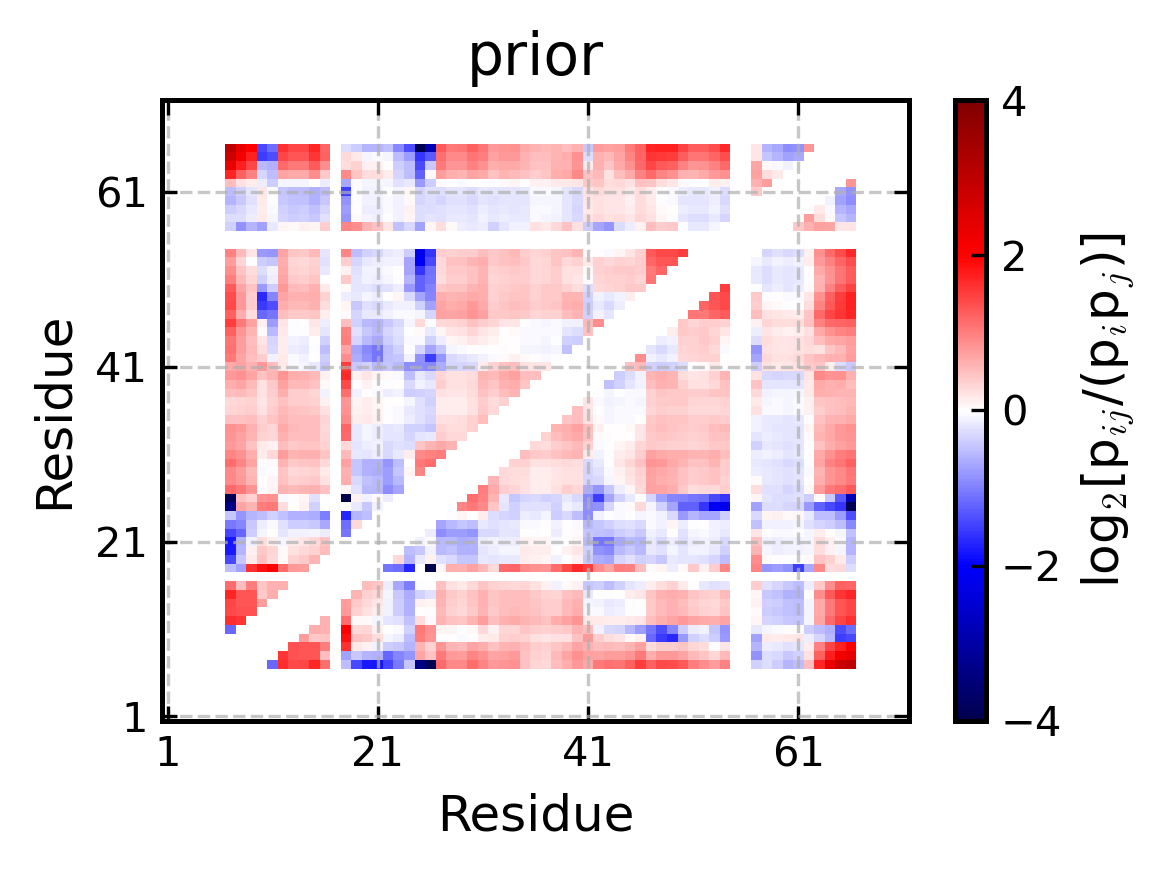

In [16]:
# =========================
# Residue pairwise helix cooperativity from DSSP
# C_ij = p_ij / (p_i * p_j)
# =========================

# =========================
# PARAMETERS
# =========================
helical_states = np.array(['H', 'G', 'I'])
weights = opes_weights
W = weights.sum()

pmin = 0.01     # mask residues with very low helix probability
min_sep = 4     # minimum sequence separation for plotting

# =========================
# DSSP → helical mask
# =========================
# dssp: (n_frames,), each entry is a string
n_frames = len(dssp)
n_residues = len(dssp[0])

# Convert DSSP strings to array of characters
dssp_chars = np.array([list(s) for s in dssp])  # (frames, residues)

# Boolean mask: 1 if helical (H/G/I)
is_helical = np.isin(dssp_chars, helical_states).astype(float)

# =========================
# Weighted single-residue probabilities p_i
# =========================
P_single = (is_helical * weights[:, None]).sum(axis=0) / W

# Mask low-probability residues
mask_prob = P_single >= pmin

# =========================
# Pairwise cooperativity matrix
# =========================
coop = np.full((n_residues, n_residues), np.nan)

for i in range(n_residues):
    if not mask_prob[i]:
        continue

    xi = is_helical[:, i]

    for j in range(i, n_residues):
        if not mask_prob[j]:
            continue

        # skip near-diagonal
        if abs(i - j) < min_sep:
            continue

        xj = is_helical[:, j]

        # weighted joint probability p_ij
        p_ij = (xi * xj * weights).sum() / W

        denom = P_single[i] * P_single[j]
        coop_ij = p_ij / denom if denom > 0 else np.nan

        coop[i, j] = coop_ij
        coop[j, i] = coop_ij  # symmetry

# =========================
# Plot (log2 cooperativity)
# =========================
plt.figure(figsize=(4, 3))
im = plt.imshow(
    np.log2(coop),
    origin='lower',
    cmap='seismic',
    aspect='auto',
    vmin=-4, vmax=4
)

cbar = plt.colorbar(im)
cbar.set_label("log$_2$[p$_{ij}$/(p$_i$p$_j$)]")

plt.xlabel("Residue")
plt.ylabel("Residue")

plt.xticks(ticks=[0, 20, 40, 60], labels=[1, 21, 41, 61])
plt.yticks(ticks=[0, 20, 40, 60], labels=[1, 21, 41, 61])
plt.title('prior')

plt.tight_layout()
plt.savefig(savepath + "helix_cooperativity_residue_matrix_prior.pdf")



In [6]:
# cooperativity ACTR controls:
# fragment ACTR at 310 K
# full-length ACTR at 440 K

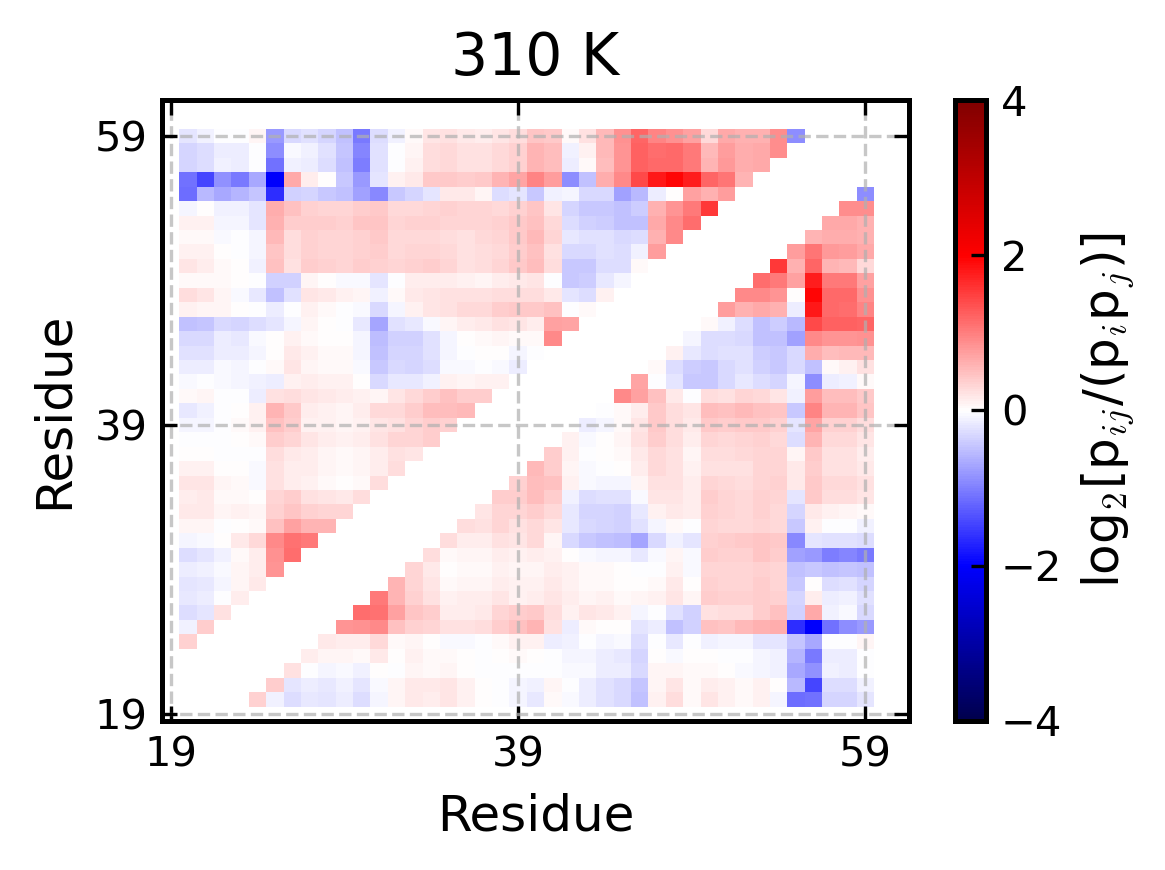

In [7]:
# fragment ACTR at 310 K
path = '../OPES_multiT/fragment_helix_ACTR/NEW_PRODUCTION_OPES_multiT_300K_noHMR/alldata/'
nsims=5
T = 310
T0 = 300
kb=0.008314

# load data and concatenate (and plot distributions of individual trajectories)
for sim in range(nsims):
    if sim==0:
        data = read_colvar(path+f'COLVAR.{sim}')[::5]
        with open(path+f'dssp{sim}.dat') as f:
            dssp = [line.strip() for line in f]
        # Time arrays in μs
        time_data = data[:, 0] / 1e6        # ps -> μs
        # Apply cutoff at 5 µs
        mask_data = time_data <= 5.0 
        data = data[mask_data]
        dssp =  np.array(dssp)[mask_data]
    else:
        tmpdata = read_colvar(path+f'COLVAR.{sim}')[::5]
        with open(path+f'dssp{sim}.dat') as f:
            tmpdssp = [line.strip() for line in f]
        # Time arrays in μs
        time_data = tmpdata[:, 0] / 1e6        # ps -> μs
        # Apply cutoff at 5 µs
        mask_data = time_data <= 5.0 
        tmpdata = tmpdata[mask_data]
        tmpdssp = np.array(tmpdssp)[mask_data]
        data = np.concatenate((data, tmpdata), axis=0)
        dssp = np.concatenate((dssp, tmpdssp), axis=0)

# weights
bias = data[:,2]
ene = data[:,1] # U
logw = (bias + (1 - T0 / T) * ene) / (kb * T0)
w = softmax(logw)
w = w/np.sum(w)
mask = w != 0
w = w[mask]
dssp = dssp[mask]

# =========================
# Residue pairwise helix cooperativity from DSSP
# C_ij = p_ij / (p_i * p_j)
# =========================

# =========================
# PARAMETERS
# =========================
helical_states = np.array(['H', 'G', 'I'])
weights = w
W = weights.sum()

pmin = 0.01     # mask residues with very low helix probability
min_sep = 4     # minimum sequence separation for plotting

# =========================
# DSSP → helical mask
# =========================
# dssp: (n_frames,), each entry is a string
n_frames = len(dssp)
n_residues = len(dssp[0])

# Convert DSSP strings to array of characters
dssp_chars = np.array([list(s) for s in dssp])  # (frames, residues)

# Boolean mask: 1 if helical (H/G/I)
is_helical = np.isin(dssp_chars, helical_states).astype(float)

# =========================
# Weighted single-residue probabilities p_i
# =========================
P_single = (is_helical * weights[:, None]).sum(axis=0) / W

# Mask low-probability residues
mask_prob = P_single >= pmin

# =========================
# Pairwise cooperativity matrix
# =========================
coop = np.full((n_residues, n_residues), np.nan)

for i in range(n_residues):
    if not mask_prob[i]:
        continue

    xi = is_helical[:, i]

    for j in range(i, n_residues):
        if not mask_prob[j]:
            continue

        # skip near-diagonal
        if abs(i - j) < min_sep:
            continue

        xj = is_helical[:, j]

        # weighted joint probability p_ij
        p_ij = (xi * xj * weights).sum() / W

        denom = P_single[i] * P_single[j]
        coop_ij = p_ij / denom if denom > 0 else np.nan

        coop[i, j] = coop_ij
        coop[j, i] = coop_ij  # symmetry

# =========================
# Plot (log2 cooperativity)
# =========================
plt.figure(figsize=(4, 3))
im = plt.imshow(
    np.log2(coop),
    origin='lower',
    cmap='seismic',
    aspect='auto',
    vmin=-4, vmax=4
)

cbar = plt.colorbar(im)
cbar.set_label("log$_2$[p$_{ij}$/(p$_i$p$_j$)]")

plt.xlabel("Residue")
plt.ylabel("Residue")

plt.xticks(ticks=[0, 20, 40], labels=[19, 39, 59])
plt.yticks(ticks=[0, 20, 40], labels=[19, 39, 59])
plt.title('310 K')

plt.tight_layout()
plt.savefig(savepath + "fragmentACTR_helix_cooperativity_residue_matrix_310K.pdf")



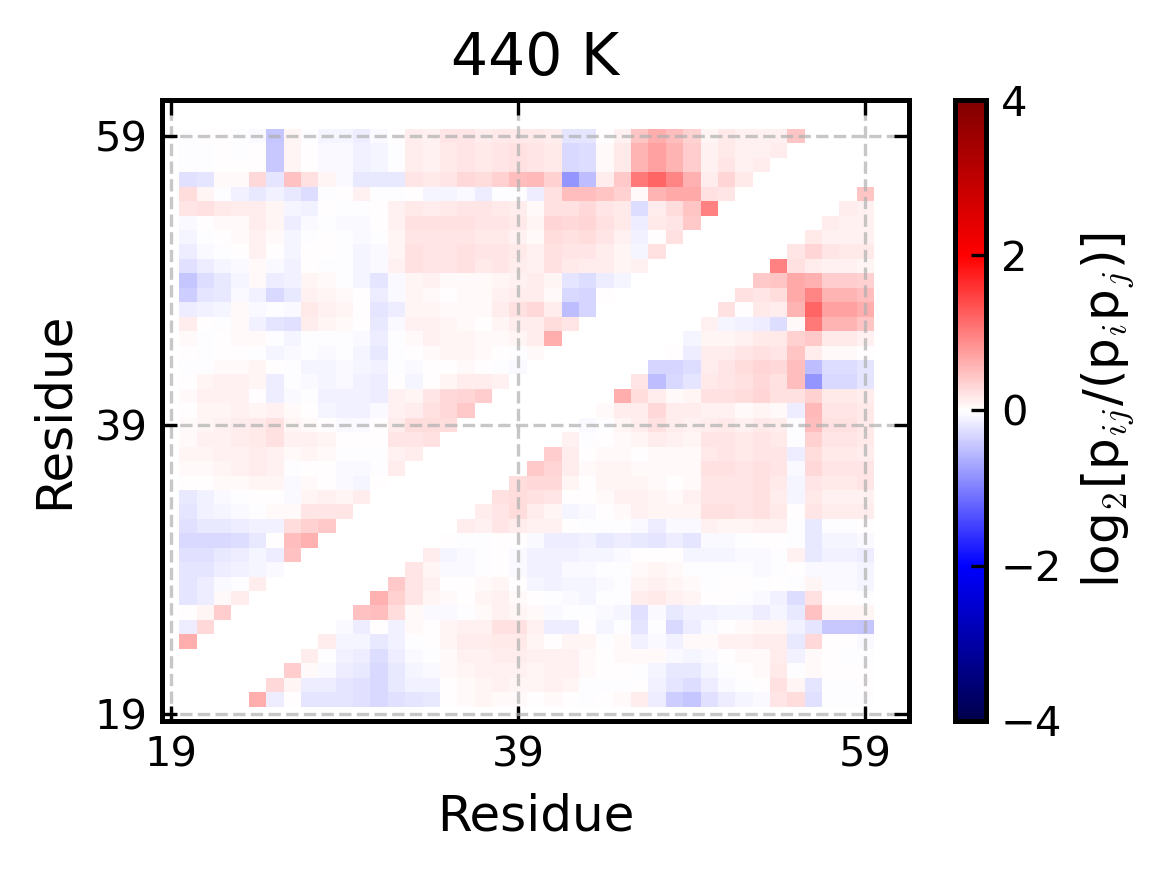

In [19]:
# fragment ACTR at 440 K
path = '../OPES_multiT/fragment_helix_ACTR/NEW_PRODUCTION_OPES_multiT_300K_noHMR/alldata/'
nsims=5
T = 440
T0 = 300
kb=0.008314

# load data and concatenate (and plot distributions of individual trajectories)
for sim in range(nsims):
    if sim==0:
        data = read_colvar(path+f'COLVAR.{sim}')[::5]
        with open(path+f'dssp{sim}.dat') as f:
            dssp = [line.strip() for line in f]
        # Time arrays in μs
        time_data = data[:, 0] / 1e6        # ps -> μs
        # Apply cutoff at 5 µs
        mask_data = time_data <= 5.0 
        data = data[mask_data]
        dssp =  np.array(dssp)[mask_data]
    else:
        tmpdata = read_colvar(path+f'COLVAR.{sim}')[::5]
        with open(path+f'dssp{sim}.dat') as f:
            tmpdssp = [line.strip() for line in f]
        # Time arrays in μs
        time_data = tmpdata[:, 0] / 1e6        # ps -> μs
        # Apply cutoff at 5 µs
        mask_data = time_data <= 5.0 
        tmpdata = tmpdata[mask_data]
        tmpdssp = np.array(tmpdssp)[mask_data]
        data = np.concatenate((data, tmpdata), axis=0)
        dssp = np.concatenate((dssp, tmpdssp), axis=0)

# weights
bias = data[:,2]
ene = data[:,1] # U
logw = (bias + (1 - T0 / T) * ene) / (kb * T0)
w = softmax(logw)
w = w/np.sum(w)
mask = w != 0
w = w[mask]
dssp = dssp[mask]

# =========================
# Residue pairwise helix cooperativity from DSSP
# C_ij = p_ij / (p_i * p_j)
# =========================

# =========================
# PARAMETERS
# =========================
helical_states = np.array(['H', 'G', 'I'])
weights = w
W = weights.sum()

pmin = 0.01     # mask residues with very low helix probability
min_sep = 4     # minimum sequence separation for plotting

# =========================
# DSSP → helical mask
# =========================
# dssp: (n_frames,), each entry is a string
n_frames = len(dssp)
n_residues = len(dssp[0])

# Convert DSSP strings to array of characters
dssp_chars = np.array([list(s) for s in dssp])  # (frames, residues)

# Boolean mask: 1 if helical (H/G/I)
is_helical = np.isin(dssp_chars, helical_states).astype(float)

# =========================
# Weighted single-residue probabilities p_i
# =========================
P_single = (is_helical * weights[:, None]).sum(axis=0) / W

# Mask low-probability residues
mask_prob = P_single >= pmin

# =========================
# Pairwise cooperativity matrix
# =========================
coop = np.full((n_residues, n_residues), np.nan)

for i in range(n_residues):
    if not mask_prob[i]:
        continue

    xi = is_helical[:, i]

    for j in range(i, n_residues):
        if not mask_prob[j]:
            continue

        # skip near-diagonal
        if abs(i - j) < min_sep:
            continue

        xj = is_helical[:, j]

        # weighted joint probability p_ij
        p_ij = (xi * xj * weights).sum() / W

        denom = P_single[i] * P_single[j]
        coop_ij = p_ij / denom if denom > 0 else np.nan

        coop[i, j] = coop_ij
        coop[j, i] = coop_ij  # symmetry

# =========================
# Plot (log2 cooperativity)
# =========================
plt.figure(figsize=(4, 3))
im = plt.imshow(
    np.log2(coop),
    origin='lower',
    cmap='seismic',
    aspect='auto',
    vmin=-4, vmax=4
)

cbar = plt.colorbar(im)
cbar.set_label("log$_2$[p$_{ij}$/(p$_i$p$_j$)]")

plt.xlabel("Residue")
plt.ylabel("Residue")

plt.xticks(ticks=[0, 20, 40], labels=[19, 39, 59])
plt.yticks(ticks=[0, 20, 40], labels=[19, 39, 59])
plt.title('440 K')

plt.tight_layout()
plt.savefig(savepath + "fragmentACTR_helix_cooperativity_residue_matrix_440K.pdf")



/tmp/ipykernel_653351/950808581.py:114: RuntimeWarning: divide by zero encountered in log2
  np.log2(coop),


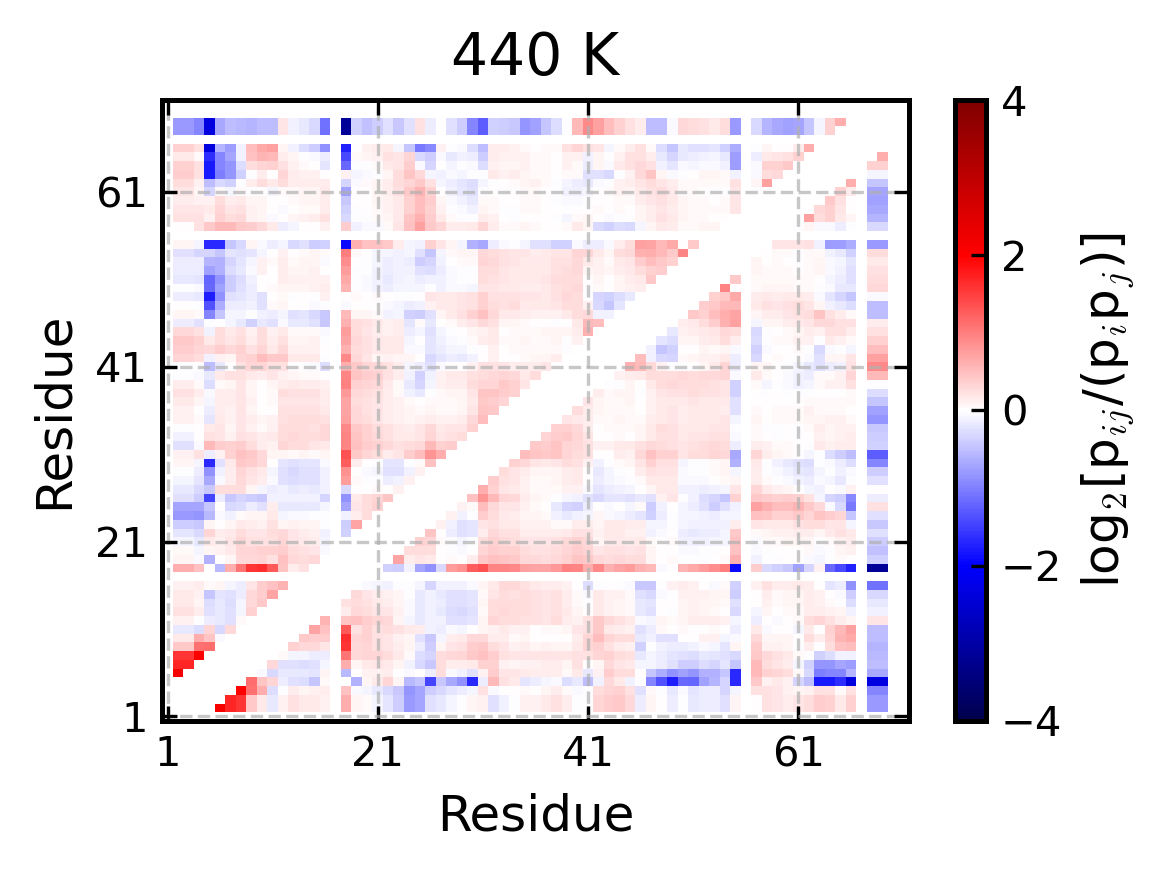

In [20]:
# full-length ACTR at 440 K
path = '../OPES_multiT/ACTR/NEW_PRODUCTION_300K_2fs_80steps/alldata/'
nsims=5
T = 440
T0 = 300
kb=0.008314

# load data and concatenate (and plot distributions of individual trajectories)
for sim in range(nsims):
    if sim==0:
        data = read_colvar(path+f'COLVAR.{sim}')
        with open(path+f'dssp{sim}.dat') as f:
            dssp = [line.strip() for line in f]
        # Time arrays in μs
        time_data = data[:, 0] / 1e6        # ps -> μs
        # Apply cutoff at 5 µs
        mask_data = time_data <= 5.0 
        data = data[mask_data]
        dssp =  np.array(dssp)[mask_data]
    else:
        tmpdata = read_colvar(path+f'COLVAR.{sim}')
        with open(path+f'dssp{sim}.dat') as f:
            tmpdssp = [line.strip() for line in f]
        # Time arrays in μs
        time_data = tmpdata[:, 0] / 1e6        # ps -> μs
        # Apply cutoff at 5 µs
        mask_data = time_data <= 5.0 
        tmpdata = tmpdata[mask_data]
        tmpdssp = np.array(tmpdssp)[mask_data]
        data = np.concatenate((data, tmpdata), axis=0)
        dssp = np.concatenate((dssp, tmpdssp), axis=0)

# weights
bias = data[:,2]
ene = data[:,1] # U
logw = (bias + (1 - T0 / T) * ene) / (kb * T0)
w = softmax(logw)
w = w/np.sum(w)
mask = w != 0
w = w[mask]
dssp = dssp[mask]

# =========================
# Residue pairwise helix cooperativity from DSSP
# C_ij = p_ij / (p_i * p_j)
# =========================

# =========================
# PARAMETERS
# =========================
helical_states = np.array(['H', 'G', 'I'])
weights = w
W = weights.sum()

pmin = 0.01     # mask residues with very low helix probability
min_sep = 4     # minimum sequence separation for plotting

# =========================
# DSSP → helical mask
# =========================
# dssp: (n_frames,), each entry is a string
n_frames = len(dssp)
n_residues = len(dssp[0])

# Convert DSSP strings to array of characters
dssp_chars = np.array([list(s) for s in dssp])  # (frames, residues)

# Boolean mask: 1 if helical (H/G/I)
is_helical = np.isin(dssp_chars, helical_states).astype(float)

# =========================
# Weighted single-residue probabilities p_i
# =========================
P_single = (is_helical * weights[:, None]).sum(axis=0) / W

# Mask low-probability residues
mask_prob = P_single >= pmin

# =========================
# Pairwise cooperativity matrix
# =========================
coop = np.full((n_residues, n_residues), np.nan)

for i in range(n_residues):
    if not mask_prob[i]:
        continue

    xi = is_helical[:, i]

    for j in range(i, n_residues):
        if not mask_prob[j]:
            continue

        # skip near-diagonal
        if abs(i - j) < min_sep:
            continue

        xj = is_helical[:, j]

        # weighted joint probability p_ij
        p_ij = (xi * xj * weights).sum() / W

        denom = P_single[i] * P_single[j]
        coop_ij = p_ij / denom if denom > 0 else np.nan

        coop[i, j] = coop_ij
        coop[j, i] = coop_ij  # symmetry

# =========================
# Plot (log2 cooperativity)
# =========================
plt.figure(figsize=(4, 3))
im = plt.imshow(
    np.log2(coop),
    origin='lower',
    cmap='seismic',
    aspect='auto',
    vmin=-4, vmax=4
)

cbar = plt.colorbar(im)
cbar.set_label("log$_2$[p$_{ij}$/(p$_i$p$_j$)]")

plt.xlabel("Residue")
plt.ylabel("Residue")

plt.xticks(ticks=[0, 20, 40, 60], labels=[1, 21, 41, 61])
plt.yticks(ticks=[0, 20, 40, 60], labels=[1, 21, 41, 61])
plt.title('440 K')

plt.tight_layout()
plt.savefig(savepath + "ACTR_helix_cooperativity_residue_matrix_440K.pdf")

